In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing

import numpy as np

from dotenv import load_dotenv
import os
import sqlalchemy
from config import *
import plotly.graph_objects as go
import plotly.express as px
from class_lib.feature_minorizer import FeatureMinorizer
from class_lib.category_recoverer import CategoryRecoverer
from class_lib.extra_feature_gen import ExtraFeatureGenerator

In [3]:
ACCOUNT_ID = 47

from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True) 

In [4]:
events = pd.read_csv(f'{ACCOUNT_ID}/events.csv')
events['event_time'] = pd.to_datetime(events['event_time'])
sessions = pd.read_csv(f'{ACCOUNT_ID}/sessions.csv')

## Preprocessing

In [ ]:
DOTENV_PATH = './.env'
OUTPUT_PATH = 'results/'
MODELS_PATH = 'models/'
LOGS_PATH = 'logs/'

minorisation_THS = 100
minorisation_percentage_threshold = .20
max_percentage_obs = .005

min_samples_leaf_percantage = 0.1

#avaliable types = ['ignore', 'mean','quantilies']
NAN_AGG_TYPE_AEB = 'ignore'
NAN_AGG_TYPE_FS = 'ignore'
NAN_AGG_TYPE_CRM = 'ignore'

crm_cat_features = ['billing_city',
                    'billing_country',
                    'shipping_billing_same',
                    'lineitem_name',
                    'lineitem_category',
                    'lineitem_subcategory',
                    'is_company',
                    'free_shipping',
                    'payment_type',
                    'time_of_purchase',
                    'purchase_day_of_week',
                    'age_group',
                    'has_discount']

crm_float_features = ['age',
                      'order_total',
                      'items_total']

#should not be minirozied due to limited features number
ignore_minorization_features = ['seconds_to','channel', 'name']

product_matrix_params = {'top_pairs_num': 5, 'categories_for_pairs': False, 'calculate_pairs': False}
ltv_m_tree_params = {'criterion': 'variance', 'max_depth': 6, 'min_samples_leaf': 100, 'random_state': 0, 'c': 100000}
ltv_tree_params = {'criterion': 'mse', 'max_depth': 5, 'min_samples_leaf': 100, 'random_state': 0}
fpv_tree_params = {'criterion': 'mse', 'max_depth': 5, 'min_samples_leaf': 100, 'random_state': 0}
aov_tree_params = {'criterion': 'mse', 'max_depth': 5, 'min_samples_leaf': 100, 'random_state': 0}
ltv_tree_params_beh = {'criterion': 'mse', 'max_depth': 5, 'min_samples_leaf': 0, 'random_state': 0}
spr_tree_params = {'max_depth': 5,'min_samples_leaf': 100, 'random_state': 0}
spr_mixed_tree_params = {'max_depth': 5, 'random_state': 0}
sao_tree_params = {'max_depth': 5, 'random_state': 0}
aeb_atb_tree_params = {'max_depth': 5, 'random_state': 0}
fs_ss_tree_params = {'max_depth': 5, 'random_state': 0}
fs_atb_tree_params = {'max_depth': 5, 'random_state': 0}

In [ ]:
def applyParallel(dfGrouped, func, *kwards):
    Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group,*kwards) for name, group in dfGrouped)
    return pd.concat(retLst)

In [ ]:
events[events.url.str.contains('https://danija.lt/greitas-uzsakymas')].head()

In [ ]:
from itertools import tee
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def add_to_global_data(data, source_targer_key):
    if data.get(source_targer_key,None):
        data[source_targer_key] +=1
    else:
        data[source_targer_key] = 1

def unfold_dict_to_dataframe(global_data):
    source = []
    target = []
    engagments = []
    for key,value in global_data.items():
        temp = key.split('=>')
        source.append(temp[0])
        target.append(temp[1])
        engagments.append(value)
    return pd.DataFrame(data = {'source' : source, 'target' : target, 'engagments' : engagments})

from __future__ import division

def rescale(values, new_min = 0, new_max = 100):
    output = []
    old_min, old_max = min(values), max(values)

    for v in values:
        new_v = (new_max - new_min) / (old_max - old_min) * (v - old_min) + new_min
        output.append(new_v)

    return output

def unfold_dict_to_dataframe_multiplt(global_data):
    source = []
    target = []
    count = []
    atb = []
    for key,value in global_data.items():
        temp = key.split('=>')
        source.append(temp[0])
        target.append(temp[1])
        count.append(value['count'])
        atb.append(value['atb'])
    return pd.DataFrame(data = {'source' : source, 'target' : target, 'count' : count,'atb' : atb})

class AutoId:
    def __init__(self, **kwargs):
        self.di = kwargs.get("di", {})
        self.loc = 0
    def get(self, value):
        if value not in self.di:
            self.di[value] = self.loc
            self.loc += 1
        return self.di[value]
    def get_list(self, li):
        return [*map(self.get, li)]
    def set_list(self,li):
        [*map(self.get, li)]
        
def make_node_data(data_plot, all_values_encoded):
    in_f = []
    out_f = []
    in_f_v = []
    out_f_v = []
    for i in all_values:
        in_f.append(f'<br />incoming : {data_plot[data_plot.target == i].shape[0]}')
        out_f.append(f'<br />outcomming : {data_plot[data_plot.source == i].shape[0]}')
        in_f_v.append(f'<br />incoming_v : {data_plot[data_plot.target == i].engagments.sum()}')
        out_f_v.append(f'<br />outcomming_v : {data_plot[data_plot.source == i].engagments.sum()}')
    return pd.DataFrame(
        data = {
            'customdata' : all_values,
            'in_f' : in_f,
            "out_f" : out_f,
            "in_f_v": in_f_v,
            "out_f_v": out_f_v,        
            }
        )

def make_node_data_m(data_plot, all_values_encoded):
    in_f = []
    out_f = []
    in_f_v = []
    out_f_v = []
    for i in all_values:
        in_f.append(f'<br />incoming : {data_plot[data_plot.target == i].shape[0]}')
        out_f.append(f'<br />outcomming : {data_plot[data_plot.source == i].shape[0]}')
        in_f_v.append(f'<br />incoming_v : {data_plot[data_plot.target == i]["count"].sum()}')
        out_f_v.append(f'<br />outcomming_v : {data_plot[data_plot.source == i]["count"].sum()}')
    return pd.DataFrame(
        data = {
            'customdata' : all_values,
            'in_f' : in_f,
            "out_f" : out_f,
            "in_f_v": in_f_v,
            "out_f_v": out_f_v,        
            }
        )

def split(a, t):
    k, m = divmod(len(a), t)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(t))

def make_text(data,num = 2,prefix = None):
    text = ''
    data['c_c'] = data['customdata'].apply(lambda x : x.split(prefix)[-1])
    items = (data.index.astype('str') +". " + data['c_c']).values
    splits = list(split(items, num))
    lens = [len((max(i, key=len))) for i in list(splits)]
    for row in zip(*splits):
        temp = ''
        for i,v in enumerate(row):
            if i == 0:
                temp = v
            else:
                temp+= (" " * lens[i-1])[len(row[i-1]):] + v
            
        text+=temp +'<br>'
    return text

In [ ]:
guests_with_atb = events.groupby('session_id').apply(lambda x : x if 'add_to_basket' in x['name'].unique() else None)
guests_with_atb = guests_with_atb[guests_with_atb['guest_id'].notnull()]
guests_with_atb = guests_with_atb[guests_with_atb['referer'] != 'NaN']
guests_with_atb = guests_with_atb[guests_with_atb['url'].notnull()]

In [ ]:
page_atb_events = events[events['name'].isin(['add_to_basket','page_view'])]

In [ ]:
print(guests_with_atb.iloc[0:5])

In [ ]:
urls_with_atb = []
for url in events[events.name =='add_to_basket'].url.unique()[:100]:
    temp = events[events.url == url]
    counts = temp['name'].value_counts()
    if counts['add_to_basket'] > 3:
        urls_with_atb.append(url)

In [ ]:
print(urls_with_atb[:5])

In [ ]:
base_url = 'https://danija.lt/greitas-uzsakymas'
based_events = events[events.url.str.contains(base_url)]

In [ ]:
print(based_events.head())

In [ ]:
import json
import ast

In [ ]:
test_dict = json.loads('{"Nikhil" : 1, "Akshat" : 2, "Akash" : 3}')
type(test_dict)

In [ ]:
based_events['event_data'] = based_events['event_data'].apply(ast.literal_eval)
for item in ['name', 'innerText','id','url']:
    based_events[f'event_data_{item}'] = based_events['event_data'].apply(lambda x : x.get(item,float('NaN')) if x.get(item,float('NaN')) != '' else float('NaN'))

In [ ]:
based_events = based_events[~based_events.name.str.contains('scroll')]
based_events = based_events[~based_events.name.str.contains('go_to_checkout')]

In [ ]:
normalized = pd.json_normalize(based_events['event_data'])

In [ ]:
based_events.shape, normalized.shape

In [ ]:
atb_eventsbased_events = pd.concat([based_events, normalized.reindex(based_events.index)],axis=1)
based_events.event_data_name.value_counts()

In [ ]:
based_events.event_data_innerText.value_counts()

In [ ]:
based_events.referer.value_counts()

In [ ]:
a = 'https://danija.lt/prekes/6753-balti-odiniai-moteriski-bateliai.html?fbclid=IwAR34bsnMzWH5Db9R6oq5U6ruqoS8BwKAyz5dmj5pwHrPXOcVTjSTFjkLVxU'
print(a if '?' not in a else '?'.join(a.split('?')[:-1]))

In [ ]:
b = 'https://danija.lt/prekes/6753-balti-odiniai-moteriski-bateliai.html?fbclid=IwAR34bsnMzWH5Db9R6oq5U6ruqoS8BwKAyz5dmj5pwHrPXOcVTjSTFjkLVxU'
print('/'.join(b.split('/')[:-1]))

In [ ]:
c = 'https://danija.lt/prekes/6753-balti-odiniai-moteriski-bateliai.html?fbclid=IwAR34bsnMzWH5Db9R6oq5U6ruqoS8BwKAyz5dmj5pwHrPXOcVTjSTFjkLVxU'
print('.html'.join(c.split('.html')[:-1]))

In [ ]:
to_minorize = based_events.copy()
based_events = to_minorize.copy()
# ?

In [ ]:
based_events['event_data_innerText']

In [ ]:
based_events['event_data_name'] = based_events['event_data_name'] +'_'+ based_events['event_data_innerText']

In [ ]:
cat_features = ['referer','event_data_innerText','event_data_name','event_data_url']

In [ ]:
minorizer_features = FeatureMinorizer(0.1, 0.001)

based_events = minorizer_features.inplace_minorization(based_events, cat_features, [])

In [ ]:
based_events = minorizer_features.minorise_feature(based_events, 'event_data_url', 100)
based_events = minorizer_features.minorise_feature(based_events, 'event_data_name', 1000)

In [ ]:
based_events.event_data_url.apply(lambda x: str(x)).value_counts()

In [ ]:
based_events.event_data_name.value_counts()

In [ ]:
for f in cat_features:
    based_events[f] = based_events[f].fillna('')

In [ ]:
for f in cat_features:
    based_events[f] = based_events[f].replace({'Other' : ''})

In [ ]:
based_events.referer = based_events.referer.replace({'':'Other'})

----------------

## My log compilation

In [ ]:
events = pd.read_csv('events_adds.csv').drop('Unnamed: 0', axis=1)

In [ ]:
events.info()

In [9]:
from datetime import datetime, timedelta
import tqdm

In [ ]:
def pseudo_event(data):
    session = 0
    adds = pd.DataFrame()
    pbar = tqdm.tqdm(total=len(data.index))
    
    for index, row in data.iterrows():
        if row['session_id'] != session:
            row['url'] = row['channel']
            row['event_time'] = row['event_time'] - timedelta(milliseconds=1)
            adds = adds.append(row)
            session = row['session_id']
        pbar.update(1)
    
    pbar.close()
    return adds

In [ ]:
def post_event(data):
    check = ['Direct', 'Organic Search', 'Social', 'Paid Search', 'Email']
    session = 0
    atb = pd.DataFrame()
    atb_sessions = list()
    natb = pd.DataFrame()
    pbar = tqdm.tqdm(total=len(data.index))
    trigger = 0
    
    for index, row in data[::-1].iterrows():
        if row['url'] in check:
            row['concept:name'] = row['url']
        if row['session_id'] != session:
            session = row['session_id']
            trigger = 0
        if row['concept:name'] == 'add_to_basket':
            trigger = 1
            atb_sessions.append(session)
        if trigger == 1:
            atb = atb.append(row)
        else:
            natb = natb.append(row)
        
        pbar.update(1)
    
    pbar.close()
    return atb, atb_sessions, natb

In [ ]:
atb, atb_sessions, natb = post_event(events)

In [50]:
atb.to_csv('atb.csv')
natb.to_csv('natb.csv')

In [ ]:
with open('atb_sessions.txt', 'w') as f:
    for item in atb_sessions:
        f.write("%s\n" % item)

In [ ]:
atb[atb['session_id'] == 26442759]

In [ ]:
def clear_atb(data):
    #pbar = tqdm.tqdm(total=len(data.index))
    check = ['Direct', 'Organic Search', 'Social', 'Paid Search', 'Email']
    data_1 = pd.DataFrame()
    
    for index, row in data.iterrows():
        if row['url'] in check:
            row['concept:name'] = row['url']
        data_1 = data_1.append(row)
        #pbar.update(1)
        
    #pbar.close()
    return data_1

In [ ]:
# one = events.loc[events['session_id'] == 24105616].head().reset_index(drop=True)
events_fatb = events[events['concept:name'] == 'add_to_basket']
events_fatb = clear_atb(events_fatb)

In [ ]:
events = natb

In [ ]:
events = events[events['session_id'].isin(atb_sessions) == False]

In [ ]:
len(events['session_id'].unique())

In [ ]:
# test_events = events.loc[events['session_id'] == 26442748]
adds = pseudo_event(events)

In [ ]:
adds.to_csv('adds.csv')

In [ ]:
adds = pd.read_csv('adds.csv').drop('Unnamed: 0', axis=1)#.reset_index(drop=True)
adds.session_id = adds.session_id.astype(int)

In [ ]:
adds.head()

In [ ]:
len(adds)

------------------------

In [6]:
atb = pd.read_csv('atb.csv').drop('Unnamed: 0', axis=1)#.reset_index(drop=True)
atb.session_id = atb.session_id.astype(int)
natb = pd.read_csv('natb.csv').drop('Unnamed: 0', axis=1)#.reset_index(drop=True)
natb.session_id = natb.session_id.astype(int)

In [10]:
def post_event(data):
    session = 0
    adds = pd.DataFrame()
    pbar = tqdm.tqdm(total=len(natb.index))
    
    for index, row in data[::-1].iterrows():
        if row['session_id'] != session:
            row = row
            row['url'] = 'not_atb'
            row['concept:name'] = 'not_atb'
            row['event_time'] = row['event_time'] + timedelta(milliseconds=1)
            #adds = pd.concat([adds, row], ignore_index=True)
            adds = adds.append(row)
            session = row['session_id']
        pbar.update(1)
    
    pbar.close()
    return adds

In [6]:
natb['event_time'] = pd.to_datetime(natb['event_time'])

In [7]:
natb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447734 entries, 0 to 447733
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   session_id    447734 non-null  int64         
 1   guest_id      447734 non-null  object        
 2   channel       447734 non-null  object        
 3   event_time    447734 non-null  datetime64[ns]
 4   created       447734 non-null  object        
 5   referer       447734 non-null  object        
 6   url           447734 non-null  object        
 7   name          447734 non-null  object        
 8   event_data    447734 non-null  object        
 9   concept:name  447734 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 34.2+ MB


In [11]:
import warnings
warnings.filterwarnings("ignore")

not_atb_events = post_event(natb)

100%|██████████████████████████████████| 447734/447734 [23:05<00:00, 323.18it/s]


In [12]:
not_atb_events.head()

,session_id,guest_id,channel,event_time,created,referer,url,name,event_data,concept:name
447733,26447829,vf-1637002622779-vJCJAJ4Sx1KcmKUvuWrcH,Organic Search,2022-02-16 09:05:04.700,2022-02-16 09:05:41.132870+00:00,https://www.google.com/,not_atb,document_mouse_enter,{},not_atb
447729,26447828,vf-1628429599182-ORVa8y7mP9ec3htapcH4o,Referral,2022-02-16 09:04:28.727,2022-02-16 09:05:41.132870+00:00,https://m.delfi.lt/,not_atb,scroll_50,{},not_atb
447726,26447827,vf-1628479739734-di5HALPtfftbz2QPOnoO0,Organic Search,2022-02-16 09:02:04.910,2022-02-16 09:05:41.132870+00:00,https://www.google.com/,not_atb,scroll_50,{},not_atb
447723,26447826,vf-1629877284653-17z8xTZUkNnb3ByXio3Sf,Direct,2022-02-16 09:02:07.917,2022-02-16 09:05:41.132870+00:00,https://danija.lt/,not_atb,scroll_100,{},not_atb
447719,26447825,vf-1644953608775-JB91BQB5VKJgLikugvu-_,Social,2022-02-16 09:00:28.129,2022-02-16 09:05:41.132870+00:00,https://lm.facebook.com/,not_atb,document_mouse_enter,{},not_atb


In [13]:
natb = pd.concat([natb,not_atb_events], ignore_index=True)

In [14]:
len(natb['session_id'].unique())

80136

In [15]:
atb = atb.sort_values(['session_id', 'event_time']).reset_index(drop=True)
natb = natb.sort_values(['session_id', 'event_time']).reset_index(drop=True)

In [49]:
natb.head()

,session_id,guest_id,channel,event_time,created,referer,url,name,event_data,concept:name
0,9767,vf-1626768085374-EUaspMG7BI_IqpqIQDd9c,Social,2022-02-12 08:03:55.138,2022-02-12 08:14:41.220319+00:00,http://m.facebook.com/,Social,page_view,{},Social
1,9767,vf-1626768085374-EUaspMG7BI_IqpqIQDd9c,Social,2022-02-12 08:03:55.139,2022-02-12 08:14:41.220319+00:00,http://m.facebook.com/,https://danija.lt/prekes/6790-juodos-odines-mo...,page_view,{},Other
2,9767,vf-1626768085374-EUaspMG7BI_IqpqIQDd9c,Social,2022-02-12 08:03:55.140,2022-02-12 08:14:41.220319+00:00,http://m.facebook.com/,not_atb,page_view,{},not_atb
3,24306,vf-1627767297699-yNpVvGTH6cdqOYyVocAu3,Direct,2022-02-11 15:59:16.578,2022-02-11 16:41:45.242179+00:00,https://danija.lt/prekes/6624-juodi-odiniai-mo...,Direct,document_mouse_enter,{},Direct
4,24306,vf-1627767297699-yNpVvGTH6cdqOYyVocAu3,Direct,2022-02-11 15:59:16.579,2022-02-11 16:41:45.242179+00:00,https://danija.lt/prekes/6624-juodi-odiniai-mo...,https://danija.lt/module/danfavoriteproducts/p...,document_mouse_enter,{},Other


In [24]:
natb['concept:name'].value_counts().nlargest(30)

Other                                                       129984
not_atb                                                      80136
https://danija.lt/moteriski                                  71544
https://danija.lt/moteriski/moteriski-aulinukai              38298
https://danija.lt/                                           36966
Social                                                       24950
Organic Search                                               20871
https://danija.lt/moteriski/bateliai                         19412
Direct                                                       18869
https://danija.lt/akcijos                                    15092
https://danija.lt/vyriski                                    10128
https://danija.lt/moteriski/moteriski-laisvalaikio-batai      9796
https://danija.lt/naujienos-2                                 8978
https://danija.lt/greitas-uzsakymas                           8419
https://danija.lt/moteriski/zieminiai-batai-2                 

In [ ]:
atb_channel = pd.DataFrame()
natb_channel = pd.DataFrame()
pbar = tqdm.tqdm(total=len(atb['session_id'].unique()))
for row in atb['session_id'].unique():
    atb_channel = atb_channel.append(atb[atb['session_id'] == row].head(1))
    pbar.update(1)
pbar.close()
pbar = tqdm.tqdm(total=len(natb['session_id'].unique()))
for row in natb['session_id'].unique():
    natb_channel = natb_channel.append(natb[natb['session_id'] == row].head(1))
    pbar.update(1)
pbar.close()

In [ ]:
natb_channel.head()

In [18]:
atb_channel.to_csv('atb_channel.csv')
natb_channel.to_csv('natb_channel.csv')

NameError: name 'atb_channel' is not defined

In [4]:
atb_channel = pd.read_csv('atb_channel.csv').drop('Unnamed: 0', axis=1)
natb_channel = pd.read_csv('natb_channel.csv').drop('Unnamed: 0', axis=1)

In [7]:
atb_natb = pd.concat([atb, natb], ignore_index=True)

In [33]:
atb_natb.sort_values(['session_id', 'event_time']).reset_index(drop=True).head(10)

,session_id,guest_id,channel,event_time,created,referer,url,name,event_data,concept:name
0,9767,vf-1626768085374-EUaspMG7BI_IqpqIQDd9c,Social,2022-02-12 08:03:55.138000,2022-02-12 08:14:41.220319+00:00,http://m.facebook.com/,Social,page_view,{},Social
1,9767,vf-1626768085374-EUaspMG7BI_IqpqIQDd9c,Social,2022-02-12 08:03:55.139000,2022-02-12 08:14:41.220319+00:00,http://m.facebook.com/,https://danija.lt/prekes/6790-juodos-odines-mo...,page_view,{},Other
2,9767,vf-1626768085374-EUaspMG7BI_IqpqIQDd9c,Social,2022-02-12 08:03:55.140000,2022-02-12 08:14:41.220319+00:00,http://m.facebook.com/,not_atb,page_view,{},not_atb
3,24306,vf-1627767297699-yNpVvGTH6cdqOYyVocAu3,Direct,2022-02-11 15:59:16.578000,2022-02-11 16:41:45.242179+00:00,https://danija.lt/prekes/6624-juodi-odiniai-mo...,Direct,document_mouse_enter,{},Direct
4,24306,vf-1627767297699-yNpVvGTH6cdqOYyVocAu3,Direct,2022-02-11 15:59:16.579000,2022-02-11 16:41:45.242179+00:00,https://danija.lt/prekes/6624-juodi-odiniai-mo...,https://danija.lt/module/danfavoriteproducts/p...,document_mouse_enter,{},Other
5,24306,vf-1627767297699-yNpVvGTH6cdqOYyVocAu3,Direct,2022-02-11 15:59:16.580000,2022-02-11 16:41:45.242179+00:00,https://danija.lt/prekes/6624-juodi-odiniai-mo...,not_atb,document_mouse_enter,{},not_atb
6,76312,vf-1626409146333-KcLBwUgM4fowNQYrCV9p4,Social,2022-02-08 19:57:23.029000,2022-02-08 20:26:46.267663+00:00,http://instagram.com/,Social,page_view,{},Social
7,76312,vf-1626409146333-KcLBwUgM4fowNQYrCV9p4,Social,2022-02-08 19:57:23.030000,2022-02-08 20:26:46.267663+00:00,http://instagram.com/,https://danija.lt/prekes/7054-juodos-odines-mo...,page_view,{},Other
8,76312,vf-1626409146333-KcLBwUgM4fowNQYrCV9p4,Social,2022-02-08 19:57:23.031000,2022-02-08 20:26:46.267663+00:00,http://instagram.com/,not_atb,page_view,{},not_atb
9,143925,vf-1627675634174-mwWQ7jb_l88gp6Zs290RQ,Direct,2022-02-02 11:08:24.752000,2022-02-02 11:36:54.471001+00:00,https://danija.lt/moteriski,Direct,page_view,{},Direct


In [38]:
atb_natb.loc[atb_natb['concept:name'] == 'add_to_basket', 'url'] = 'atb'

<AxesSubplot:>

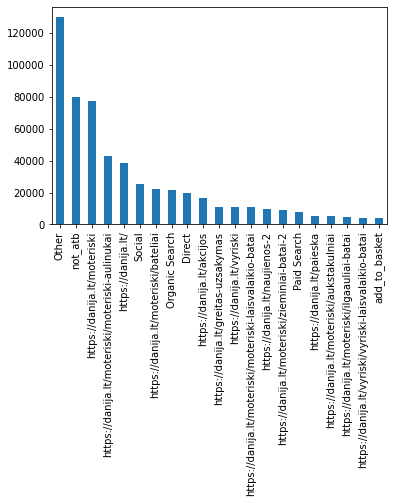

In [8]:
atb_natb['concept:name'].value_counts().nlargest(21).plot.bar()

In [44]:
atb_natb.to_csv('atb_natb.csv')

In [ ]:
print(natb_channel['concept:name'].value_counts())
natb_channel['concept:name'].value_counts().plot.bar()

In [ ]:
print(atb_channel['concept:name'].value_counts())
atb_channel['concept:name'].value_counts().plot.bar()

In [ ]:
all_channel = pd.concat([atb_channel, natb_channel], ignore_index=True)

In [ ]:
all_channel.head()

In [ ]:
print(all_channel['concept:name'].value_counts())
all_channel['concept:name'].value_counts().plot.bar()

In [5]:
import retentioneering

# load sample user behavior data as a pandas dataframe: 
data = natb

# update config to pass columns names:
retentioneering.config.update({
    'user_col': 'session_id',
    'event_col': 'concept:name',
    'event_time_col':'event_time',
})

NameError: name 'natb' is not defined

In [ ]:
data.rete.plot_graph(norm_type='node',
                     weight_col=None,
                     thresh=0.0,
                     targets = {'add_to_basket':'green',
                                'not_atb':'red'})

In [45]:
data_all = atb_natb

In [48]:
data_all.rete.plot_graph(norm_type='node',
                     weight_col=None,
                     thresh=0.8,
                     targets = {'add_to_basket':'green',
                                'not_atb':'red'})

KeyboardInterrupt: 

----------------------

In [ ]:
# import plotly.graph_objects as go
# import matplotlib
# matplotlib.use("QtAgg")

# fig = go.Figure(data=[go.Sankey(
#     node = dict(
#       pad = 15,
#       thickness = 20,
#       line = dict(color = "black", width = 0.5),
#       label = ["A1", "A2", "B1", "B2", "C1", "C2"],
#       color = "blue"
#     ),
#     link = dict(
#       source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
#       target = [2, 3, 3, 4, 4, 5],
#       value = [8, 4, 2, 8, 4, 2]
#   ))])

# fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
# fig.show()

------------

In [ ]:
len(events['session_id'].unique())

In [ ]:
events = events.append(adds)

In [ ]:
events.head()

In [ ]:
events.session_id = events.session_id.astype(int)

In [ ]:
events.head()

In [ ]:
# test_events.head()
# test_adds

In [ ]:
events.iloc[0].event_time

In [ ]:
events.iloc[0].event_time - timedelta(milliseconds=1)

In [ ]:
events = events.sort_values(['session_id', 'event_time']).reset_index(drop=True)#.drop('index', axis=1)

In [ ]:
events.loc[events['concept:name'] == 'Direct'].head()

In [ ]:
events['concept:name'].value_counts().nlargest(50)

In [ ]:
events.loc[events['channel'] == 'Email', 'referer'].value_counts()

In [ ]:
events = events.drop_duplicates(subset=events.columns.difference(['name', 'event_time', 'event_data']))

In [ ]:
events['concept:name'] = events['url'].copy()

In [ ]:
events.loc[events['name'] == 'add_to_basket', 'concept:name'] = 'add_to_basket'

In [ ]:
events.iloc[1]

In [ ]:
events.loc[events['session_id'] == 24105616].head()

In [ ]:
minorizer_features = FeatureMinorizer(0.3, 0.001)

events = minorizer_features.inplace_minorization(events, ['concept:name'], [])

In [ ]:
events = minorizer_features.minorise_feature(events, 'concept:name', 500)

In [ ]:
events['concept:name'].value_counts().nlargest(50)

In [ ]:
events['channel'].value_counts()

In [ ]:
sessions[sessions.id == 23779735]

In [ ]:
events.iloc[0]

In [ ]:
sessions[sessions['id'] == 23779735].iloc[0]

In [ ]:
events.info()

In [ ]:
len('https://danija.lt/moteriski/ilgaauliai-batai')

In [ ]:
events['session_id'].isna().value_counts()

In [ ]:
events['referer'] = events['referer'].fillna(events['channel'])

In [ ]:
# events['referer'] = events['referer'].apply(lambda x: str(x) if '/' not in str(x) or len(str(x)) < 60 else '/'.join(str(x).split('/')[:-1]))
# events['url'] = events['url'].apply(lambda x: str(x) if '/' not in str(x) or len(str(x)) < 60 else '/'.join(str(x).split('/')[:-1]))

events['referer'] = events.referer.str.split('?').apply(lambda x : x[0])
events['url'] = events.url.str.split('?').apply(lambda x : x[0])
events['concept:name'] = events['concept:name'].str.split('?').apply(lambda x : x[0])

In [ ]:
events[events['referer'].isna()].head()

In [ ]:
import pm4py
import pm4py.objects.log.importer
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

In [ ]:
parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'session_id', 
              log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ATTRIBUTE_PREFIX: 'concept:name:'}

# CASE_ID_KEY is for marking groups of events
# CASE_ATTRIBUTE_PREFIX is for marking additional attributes used to describe groups

In [ ]:
# log_csv_sessions = dataframe_utils.convert_timestamp_columns_in_df(sessions)
# log_csv_sessions = log_csv_sessions.sort_values('<timestamp_column>')
# event_log = log_converter.apply(log_csv_sessions)

log_csv_events = dataframe_utils.convert_timestamp_columns_in_df(events)
log_csv_events = log_csv_events.sort_values('event_time')
event_log = log_converter.apply(log_csv_events, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG) 

In [ ]:
# len(event_log)
len(log_csv_events)

 - 'attributes' field is obviously designed for session parameters which we will add later

In [ ]:
# how to make log with bare hands
# log = {'attributes': sessions.columns.drop('s_id')}
# log

In [ ]:
log = event_log

In [ ]:
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
xes_exporter.apply(log, 'cutlog.xes')

In [ ]:
log[1]

In [ ]:
log[0][0]

In [ ]:
print(type(log))
print(type(log[0]))
print(type(log[0][0]))

In [ ]:
from pm4py.algo.filtering.log.start_activities import start_activities_filter
from pm4py.algo.filtering.log.end_activities import end_activities_filter

log_start = start_activities_filter.get_start_activities(log, parameters={start_activities_filter.Parameters.ACTIVITY_KEY: 'concept:name'})
end_activities = end_activities_filter.get_end_activities(log, parameters={end_activities_filter.Parameters.ACTIVITY_KEY: 'concept:name'})

In [ ]:
log_start

In [ ]:
end_activities

In [ ]:
print('Всего сессий:              ', len(log))
print('Различных начальных точек: ', len(log_start))
print('Различных завершений:      ', len(end_activities))

In [ ]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(log, parameters={variants_filter.Parameters.ACTIVITY_KEY: 'concept:name'})
print(f"We have: {len(variants)} variants in our log")

In [ ]:
variants_count = case_statistics.get_variant_statistics(log, parameters={case_statistics.Parameters.ACTIVITY_KEY: 'concept:name'})
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=False)
variants_count[:20]

In [ ]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log, "concept:name")
activities

# it's a list of states

In [ ]:
import pm4py, pandas as pd, numpy as np, os
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

# for processes
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# for vizualization
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
net, initial_marking, final_marking = alpha_miner.apply(log, parameters={alpha_miner.Parameters.ACTIVITY_KEY: 'concept:name'})
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [ ]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png', alpha_miner.Parameters.ACTIVITY_KEY: 'url'}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=log)
pn_visualizer.view(gviz)

In [ ]:
heu_net = heuristics_miner.apply_heu(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: .5, 
                                                      alpha_miner.Parameters.ACTIVITY_KEY: 'concept:name'})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [ ]:
len(events)

In [ ]:
import retentioneering

# load sample user behavior data as a pandas dataframe: 
data = events

# update config to pass columns names:
retentioneering.config.update({
    'user_col': 'session_id',
    'event_col': 'concept:name',
    'event_time_col':'event_time',
})

In [ ]:
data.head()

In [ ]:
data.rete.plot_graph(norm_type='full',
                     weight_col='session_id',
                     thresh=0.8,
                     targets = {'add_to_basket':'green',
                                'lost':'red'})

In [ ]:
htmltools::save_html(data.rete.plot_graph(norm_type='full',
                     weight_col='session_id',
                     thresh=0.8,
                     targets = {'add_to_basket':'green',
                                'lost':'red'}), file = "sunburst.html")

-------------------

In [ ]:
import datetime
today = datetime.date.today()
first = today.replace(day=1)

In [ ]:
events_last_3m = events[(events.event_time > pd.to_datetime(today) - pd.Timedelta(days=90)) & (events.event_time < pd.to_datetime(today))]

In [ ]:
events_last_3m.event_time.min(), events_last_3m.event_time.max()

In [ ]:
minorizer_features = FeatureMinorizer(0.3, 0.001)

events_last_3m = minorizer_features.inplace_minorization(events_last_3m, ['url'], [])

In [ ]:
events_last_3m.url.value_counts()

In [ ]:
events_last_3m = minorizer_features.minorise_feature(events_last_3m, 'url', 2000)

In [ ]:
events_last_3m = events_last_3m[(events_last_3m.url !='Other' ) | (events_last_3m.name =='add_to_basket')]

In [ ]:
events_last_3m.event_time.min(), events_last_3m.event_time.max()

In [ ]:
def add_to_global_data(data, source_targer_key,atb_happened):
    if data.get(source_targer_key,None):
        data[source_targer_key]['count'] +=1
        if atb_happened:
            data[source_targer_key]['atb'] += 1
    else:
        data[source_targer_key] = {}
        data[source_targer_key]['count'] = 1
        if atb_happened:
            data[source_targer_key]['atb'] = 1
        else:
            data[source_targer_key]['atb'] = 0

In [ ]:
events_last_3m.url = events_last_3m.url.str.split('?').apply(lambda x : x[0])

--------------

In [ ]:
events_last_3m

In [ ]:
parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'session_id', 
              log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ATTRIBUTE_PREFIX: 'url:'}

# CASE_ID_KEY is for marking groups of events
# CASE_ATTRIBUTE_PREFIX is for marking additional attributes used to describe groups

In [ ]:
log_csv_events = dataframe_utils.convert_timestamp_columns_in_df(events_last_3m)
log_csv_events = log_csv_events.sort_values('event_time')
event_log = log_converter.apply(log_csv_events, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG) 

In [ ]:
log_csv_events.head()

In [ ]:
log = event_log

In [ ]:
log[0]

In [ ]:
log[0][0]

In [ ]:
print(type(log))
print(type(log[0]))
print(type(log[0][0]))

In [ ]:
from pm4py.algo.filtering.log.start_activities import start_activities_filter
from pm4py.algo.filtering.log.end_activities import end_activities_filter

log_start = start_activities_filter.get_start_activities(log, parameters={start_activities_filter.Parameters.ACTIVITY_KEY: 'url'})
end_activities = end_activities_filter.get_end_activities(log, parameters={end_activities_filter.Parameters.ACTIVITY_KEY: 'url'})

In [ ]:
log_start

In [ ]:
end_activities

In [ ]:
print('Всего сессий:              ', len(log))
print('Различных начальных точек: ', len(log_start))
print('Различных завершений:      ', len(end_activities))

In [ ]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(log, parameters={variants_filter.Parameters.ACTIVITY_KEY: 'url'})
print(f"We have: {len(variants)} variants in our log")

In [ ]:
variants_count = case_statistics.get_variant_statistics(log, parameters={case_statistics.Parameters.ACTIVITY_KEY: 'url'})
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)
variants_count[:10]

In [ ]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log, "url")
activities

In [ ]:
import pm4py, pandas as pd, numpy as np, os
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

# for processes
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# for vizualization
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
net, initial_marking, final_marking = alpha_miner.apply(log, parameters={alpha_miner.Parameters.ACTIVITY_KEY: 'url'})
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [ ]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png', alpha_miner.Parameters.ACTIVITY_KEY: 'url'}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=log)
pn_visualizer.view(gviz)

In [ ]:
tree = inductive_miner.apply_tree(log, parameters={alpha_miner.Parameters.ACTIVITY_KEY: 'url'})
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)

In [ ]:
net, initial_marking, final_marking = pt_converter.apply(tree, variant=pt_converter.Variants.TO_PETRI_NET)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [ ]:
heu_net = heuristics_miner.apply_heu(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: .00005,
                                                     heuristics_miner.Variants.CLASSIC.value.Parameters.ACTIVITY_KEY: 'url'})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [ ]:
import retentioneering

# load sample user behavior data as a pandas dataframe: 
data = events_last_3m

# update config to pass columns names:
retentioneering.config.update({
    'user_col': 'session_id',
    'event_col':'url',
    'event_time_col':'event_time',
})

In [ ]:
data.head()

In [ ]:
data.rete.plot_graph(norm_type='node',
                     weight_col='session_id',
                     thresh=0.2,
                     targets = {'add_to_basket':'green',
                                'lost':'red'})

---------------

In [ ]:
global_data = {}
mark_data = {}
global_list = []
def mark_by_session(df):
    temp_data = {}
    df = df.sort_values(by=['event_time'])
    if 'add_to_basket' in df['name'].unique():
        atb_happened = 1
    else:
        atb_happened = 0
    for i_r, ((i1, row1), (i2, row2)) in enumerate(pairwise(df.iterrows())):
        if row1['name'] == 'add_to_basket' or row2['name'] == 'add_to_basket':
            return
        if i_r == 0:
            left_data = row1['channel']
            right_data = row1['url']
            source_targer_key = f"{left_data}=>{right_data}"
            temp_data[source_targer_key] = {}
            temp_data[source_targer_key]['count'] = 1
            temp_data[source_targer_key]['atb'] = atb_happened
            global_list.append(temp_data)
            add_to_global_data(global_data, source_targer_key,atb_happened)
        left_data = row1['url']
        right_data = row2['url']
        if left_data == right_data:
            continue
        source_targer_key = f"{left_data}=>{right_data}"
        temp_data[source_targer_key] = {}
        temp_data[source_targer_key]['count'] = 1
        temp_data[source_targer_key]['atb'] = atb_happened
        global_list.append(temp_data)
        add_to_global_data(global_data, source_targer_key,atb_happened)
        
        
def purchase_path(df,global_data):
    df.groupby('session_id').apply(mark_by_session)
events_last_3m.groupby('guest_id').apply(purchase_path,global_data)

In [ ]:
global_data

In [ ]:
data_plot = unfold_dict_to_dataframe_multiplt(global_data)

In [ ]:
data_plot['ratio'] = data_plot['atb'] / data_plot['count'] 

In [ ]:
data_plot.sort_values(by=['ratio'],ascending=False)

In [ ]:
data_plot.ratio.quantile(0.9)

In [ ]:
data_plot.ratio.quantile(0.1)

In [ ]:
import plotly.express as px
fig = px.histogram(data_plot.ratio)
fig.show()

In [ ]:
d = data_plot[(data_plot['count'] > 25) & (data_plot.ratio > 0.1)]

In [ ]:
d

In [ ]:
d['count_rescaled'] = rescale(d['count'])

In [ ]:
global_data = {}#m.dict()
first_data = {}
last_data = {}
last_names = []

def norm(df):
    return df['event_data'].__str__().lower()

def a(df,global_data):
    df = df.sort_values(by=['event_time'])
    for i_r, ((i1, row1), (i2, row2)) in enumerate(pairwise(df.iterrows())):
#         print(i_r)
#         print(row1['name'],row1['event_data_innerText'], row1['event_data_name'])
#         print(row2['name'],row2['event_data_innerText'],row2['event_data_name'])
        name_left = row1['name']
        name_right = row2['name']
        left_data_name = '_' + row1['event_data_name'] if row1['event_data_name'] != '' else ''
        right_data_name = '_' + row2['event_data_name'] if row2['event_data_name'] != '' else ''
        left_data_text = '_' + row1['event_data_innerText'] if row1['event_data_innerText'] != '' else ''
        right_data_text = '_' + row2['event_data_innerText'] if row2['event_data_innerText'] != '' else ''
        
            
                        
        left_data = left_data_name #+ left_data_text
        right_data = right_data_name #+ right_data_text
        
        if name_left =='link_click':
            left_data =row1['event_data_url'] if row1['event_data_url'] else '_Other'
            if left_data != "_Other":
                temp = left_data.split('#')
                if len(temp) > 1 :
                    if len(temp[1]) !=0:
                        left_data = '_' + temp[1]
                    else:
                        left_data = '_Other'
                
                else:
                    temp = left_data.split('/')
                    if len(temp) !=3:
                        left_data = '_' + '/'.join(temp[3:5])
                
                

        if name_right =='link_click':
            right_data =row2['event_data_url'] if row2['event_data_url'] else '_Other'
            if right_data != "_Other":
                temp = right_data.split('#')

                if len(temp) > 1:
                    if len(temp[1]) !=0 :
                        right_data = '_' + temp[1]
                    else:
                        right_data ='_Other'
                    
                else:
                    temp = right_data.split('/')
                    if len(temp) !=3:
                        right_data = '_' + '/'.join(temp[3:5])
                        
        if i_r == 1:
#             source_targer_key = f"{row1['channel']}=>{name_left}{right_data}"
#             add_to_global_data(global_data, source_targer_key)
            source_targer_key = f"{name_left}{left_data}=>{name_right}{right_data}"
            add_to_global_data(global_data, source_targer_key)
#             print(source_targer_key)
            source_targer_key = f"prev_page_{row1['referer']}=>{name_left}{left_data}"
            add_to_global_data(global_data, source_targer_key)
        else:

            if 'pirkti' in norm(row2) and row2['name'] == 'button_click':
                source_targer_key = f"{name_left}{left_data}=>pirkti"
                
                add_to_global_data(global_data, source_targer_key)
                break
                
                
            else: #all((left_data_name,right_data_name)):
                source_targer_key = f"{name_left}{left_data}=>{name_right}{right_data}"
#                 print(source_targer_key)
                add_to_global_data(global_data, source_targer_key)
                
        if i_r + 2 == df.shape[0]:
            source_targer_key = f"{name_right}{right_data}=>END_EVENT"
            add_to_global_data(global_data, source_targer_key)
            
based_events.groupby('session_id').apply(a, global_data)
len(global_data.keys())

In [ ]:
data_plot = unfold_dict_to_dataframe_multiplt(global_data)

In [ ]:
data_plot['ratio'] = data_plot['atb'] / data_plot['count'] 

In [ ]:
data_plot.info()

In [ ]:
data_plot['engagments_f'] = data_plot.engagments